In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
from scipy.stats import linregress
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import oh_to_12pluslog, mu, mu_evol, get_velocity_profile, boxcarsmoothtrend
from src.simulations.models.insideout import insideout
load_style_sheet("papers")
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [2]:
# COLORS = ["black", "darkviolet", "navy", "blue", "green",
#     "lime", "gold", "darkorange", "crimson", "firebrick"]
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/equilibrium-paper/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
# sample = sample.filter("absz", "<=", 0.5)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

In [2]:
def equilibrium_profile(output, lookback, N = 1.5, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * i for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    radii = [r + zone_width / 2 for r in radii]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zeq = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = float("inf")
            eta = 0
        recycling = zone.history["r_eff"][idx]
        if idx == len(zone.history["time"]) - 1: idx -= 1
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        # dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        # dlnmgdt /= dt * zone.history["mgas"][idx]
        # zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling + taustar * dlnmgdt))
        sfh = insideout(radii[i])
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling - taustar / (N * tausfh)))
    return [radii, zeq]


def equilibrium_evol(output, radius, N = 1.5, zone_width = 0.1):
    lookback, mu_g, mu_o = mu_evol(output, radius, zone_width = zone_width)
    zeq = []
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    for i in range(len(lookback)):
        diff = [abs(lookback[i] - l) for l in zone.history["lookback"]]
        idx = diff.index(min(diff))
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            zeq.append(float("nan"))
            continue
        dt = zone.history["time"][idx] - zone.history["time"][idx - 1]
        # dlnmgdt = zone.history["mgas"][idx] - zone.history["mgas"][idx - 1]
        # dlnmgdt /= zone.history["mgas"][idx] * dt
        recycling = zone.history["r_eff"][idx]
        sfh = insideout(radius)
        tausfh = sfh.timescale
        zeq.append(zone.ccsne_yields["o"] / (1 + eta - mu_o[i] - recycling + taustar / (N * tausfh)))
    return [lookback, zeq]
    

def eq_gradient(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = 0.1)
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= 5 and start is None: start = i
        if radii[i] >= 10 and stop is None: stop = i
        i += 1
    oheq = [np.log10(z / vice.solar_z['o']) for z in zeq]
    # while m.isnan(oheq[start]): start += 1
    # while m.isnan(oheq[stop]): stop -= 1
    eqprof = linregress(radii[start:stop], oheq[start:stop])
    dlnzeq_dr = eqprof.slope * m.log(10)

    z_on_zeq = []
    lntaustar = []
    for i in range(start, stop):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            lntaustar.append(m.log(zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9))
        else:
            lntaustar.append(float("inf"))
        z_on_zeq.append(zone.history["z(o)"][idx] / zeq[i])
    z_on_zeq = np.mean(z_on_zeq)
    taustarprof = linregress(radii[start:stop], lntaustar)
    dlntaustar_dr = taustarprof.slope

    gradeq = z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr
    return gradeq / m.log(10)
        
    




    # print(list(zip(radii[start:stop], zeq[start:stop])))
    # oheq = [np.log10(z / vice.solar_z['o']) for z in zeq[start:stop]]
    # radii = radii[start:stop]
    # stop -= start
    # start = 0
    # while m.isnan(oheq[start]): start += 1
    # while m.isnan(oheq[stop - 1]): stop -= 1
    # eqprof = linregress(radii[start:stop], oheq[start:stop])
    # return eqprof.slope
    
    # diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    # idx = diff.index(min(diff))
    # z_on_zeq = []
    # dlnzeq_dr = []
    # dlntaustar_dr = []
    # for i in range(start, stop):
    #     zone = output.zones["zone%d" % (i)]
    #     neighbor = output.zones["zone%d" % (i + 1)]
    #     z_on_zeq.append(zone.history["z(o)"][idx] / zeq[i])
    #     dlnzeq_dr.append((zeq[i + 1] - zeq[i]) / (zeq[i] * zone_width))
    #     if zone.history["sfr"][idx]:
    #         taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar = float("inf")
    #     if neighbor.history["sfr"][idx]:
    #         taustar_n = neighbor.history["mgas"][idx] / neighbor.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar_n = float("inf")
    #     dlntaustar_dr.append((taustar_n - taustar) / (taustar * zone_width))
    # z_on_zeq = np.mean(z_on_zeq)
    # dlnzeq_dr = np.mean(dlnzeq_dr)
    # dlntaustar_dr = np.mean(dlntaustar_dr)
    # gradeq = z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr
    # gradeq /= m.log(10)
    # return gradeq
    
    # return dlnzeq_dr / m.log(10)
    # gradeq = []
    # for i in range(start, stop):
    #     zone = output.zones["zone%d" % (i)]
    #     neighbor = output.zones["zone%d" % (i + 1)]
    #     if zone.history["sfr"][idx]:
    #         taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar = float("inf")
    #     if neighbor.history["sfr"][idx]:
    #         taustar_n = neighbor.history["mgas"][idx] / neighbor.history["sfr"][idx] * 1.e-9
    #     else:
    #         taustar_n = float("inf")
    #     dlnzeq_dr = (zeq[i + 1] - zeq[i]) / (zeq[i] * zone_width)
    #     print(dlnzeq_dr)
    #     dlntaustar_dr = (taustar_n - taustar) / (taustar * zone_width)
    #     z_on_zeq = zone.history["z(o)"][idx] / zeq[i]
    #     gradeq.append(z_on_zeq * dlnzeq_dr - (1 - z_on_zeq) * dlntaustar_dr)
    # gradeq = np.mean(gradeq) / m.log(10)
    # return gradeq
    

def ism_gradient(output, lookback, zone_width = 0.1):
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    oh = []
    start = None
    stop = None
    i = 0
    while start is None or stop is None:
        if radii[i] >= 5 and start is None: start = i
        if radii[i] > 10 and stop is None: stop = i
        i += 1
    for i in range(start, stop):
        zone = output.zones["zone%d" % (i)]
        oh.append(zone.history["[o/h]"][idx])
    # print(list(zip(radii[start:stop], oh)))
    ohprof = linregress(radii[start:stop], oh)
    return ohprof.slope

In [3]:
# River model ISM and equilibrium gradients (respectively): -0.1368 -0.1656 (?)
outputs = [
    "../outputs/constant/vgas-0-linearschmidt",
    "../outputs/constant/vgas-0",
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1",
    "../outputs/constant/vgas-1p5",
    "../outputs/potential-well-deepening/gamma0p1",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/potential-well-deepening/gamma0p3",
    "../outputs/angular-momentum-dilution/betaphiin0p8",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/angular-momentum-dilution/betaphiin0p6",
    "../outputs/river/insideout"
]
outputs = [vice.output(name) for name in outputs]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_18955/3911084883.py:66: RuntimeWarning: invalid value encountered in log10
  oheq = [np.log10(z / vice.solar_z['o']) for z in zeq]
/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_18955/3911084883.py:66: RuntimeWarning: divide by zero encountered in log10
  oheq = [np.log10(z / vice.solar_z['o']) for z in zeq]


../outputs/constant/vgas-0-linearschmidt -0.0228 -0.0293
../outputs/constant/vgas-0 -0.0382 -0.0416
../outputs/constant/vgas-0p5 -0.0616 -0.0593
../outputs/constant/vgas-1 -0.0751 -0.0712
../outputs/constant/vgas-1p5 -0.0805 -0.0775


/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/jamesjohnson/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:100: RuntimeWarning: invalid value encountered in scalar multiply
  mu *= -tau_star * vgas[i]


../outputs/potential-well-deepening/gamma0p1 -0.0428 -0.0485
../outputs/potential-well-deepening/gamma0p2 -0.0528 -0.0545
../outputs/potential-well-deepening/gamma0p3 -0.0530 -0.0597
../outputs/angular-momentum-dilution/betaphiin0p8 -0.0584 -0.0641
../outputs/angular-momentum-dilution/betaphiin0p7 -0.0685 -0.0742
../outputs/angular-momentum-dilution/betaphiin0p6 -0.0780 -0.0816
../outputs/river/insideout -0.1228 -0.1289


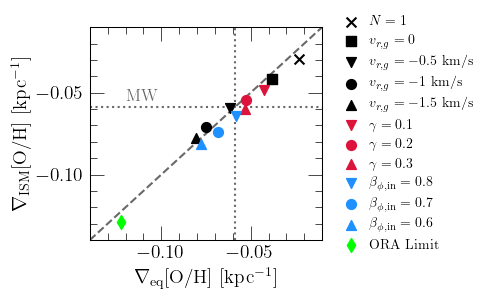

In [4]:
COLORS = [
    "black", "black",
    "black", "black", "black",
    "crimson", "crimson", "crimson",
    "dodgerblue", "dodgerblue", "dodgerblue",
    "lime"
]
MARKERS = [
    "x", "square",
    "triangle_down", "circle", "triangle_up",
    "triangle_down", "circle", "triangle_up",
    "triangle_down", "circle", "triangle_up",
    "thin_diamond"
]
LABELS = [
    r"$N = 1$", r"$v_{r,g} = 0$",
    r"$v_{r,g} = -0.5$ km/s", r"$v_{r,g} = -1$ km/s", r"$v_{r,g} = -1.5$ km/s",
    r"$\gamma = 0.1$", r"$\gamma = 0.2$", r"$\gamma = 0.3$",
    r"$\beta_{\phi,\text{in}} = 0.8$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$\beta_{\phi,\text{in}} = 0.6$",
    "ORA Limit"
]

fig = plt.figure(figsize = (5, 3.))
ax = fig.add_subplot(111)
ax.set_ylabel(r"$\nabla_\text{ISM}$[O/H] [kpc$^{-1}$]")
ax.set_xlabel(r"$\nabla_\text{eq}$[O/H] [kpc$^{-1}$]")
ax.set_xlim([-0.14, -0.01])
ax.set_ylim(ax.get_xlim())

mwslope = -0.059
kwargs = {
    "c": named_colors()["dimgrey"],
    "linestyle": "--",
    "zorder": -1000
}
ax.plot(ax.get_xlim(), ax.get_xlim(), **kwargs)
kwargs["linestyle"] = ":"
ax.axvline(mwslope, **kwargs)
ax.axhline(mwslope, **kwargs)
ax.text(-0.12, -0.055, r"MW", fontsize = 12, color = kwargs["c"])

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "marker": markers()[MARKERS[i]],
        "label": LABELS[i],
        "s": 50
    }
    if i: kwargs["zorder"] = 0
    ism = ism_gradient(outputs[i], 0)
    eq = eq_gradient(outputs[i], 0)
    print(outputs[i].name, "%.4f" % (eq), "%.4f" % (ism))
    # if LABELS[i] != "River": ax.scatter(eq, ism, **kwargs)
    ax.scatter(eq, ism, **kwargs)

kwargs = {
    "loc": mpl_loc("center left"),
    "bbox_to_anchor": (1.01, 0.5),
    "fontsize": 10,
    "scatterpoints": 1
}
leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/gradism-gradeq-comp.%s" % (ext), **kwargs)
plt.show()

In [5]:
outputs = [
    # "../outputs/constant/vgas-0",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/constant/vgas-1"
#     "../outputs/river/insideout"
]
outputs = [vice.output(name) for name in outputs]

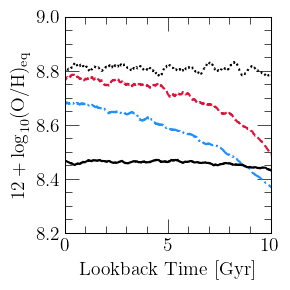

In [18]:
LABELS = [r"$v_{r,g} = 0$", r"$\gamma = 0.2$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$v_{r,g} = -1$ km/s"]
COLORS = ["black", "crimson", "dodgerblue", "black"]
LINESTYLES = [":", "--", "-.", "-"]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_ylabel(r"$12 + \log_{10}($O/H$)_\text{eq}$")
ax.set_xlim([0, 10])
ax.set_ylim([8.2, 9.0])

def plot_prediction(output, radius = 8, zone_width = 0.1, **kwargs):
    lookback, oheq = equilibrium_evol(output, radius, zone_width = zone_width)
    oheq = [np.log10(zeq / vice.solar_z['o']) for zeq in oheq]
    oheq = [oh_to_12pluslog(oh) for oh in oheq]
    oheq = boxcarsmoothtrend(lookback, oheq, window = 20)
    ax.plot(lookback, oheq, **kwargs)
    
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_prediction(outputs[i], **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/eq-vs-time.%s" % (ext), **kwargs)
plt.show()

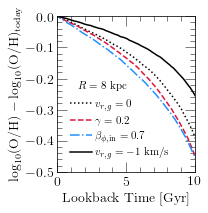

In [9]:
LABELS = [r"$v_{r,g} = 0$", r"$\gamma = 0.2$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$v_{r,g} = -1$ km/s"]
COLORS = ["black", "crimson", "dodgerblue", "black"]
LINESTYLES = [":", "--", "-.", "-"]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Lookback Time [Gyr]")
# ax.set_ylabel(r"$12 + \log_{10}($O/H$)$")
ax.set_ylabel(r"$\log_{10}($O/H$) - \log_{10}($O/H$)_\text{today}$")
ax.set_xlim([0, 10])
# ax.set_ylim([7.7, 9.])
ax.set_ylim([-0.5, 0])
# ax.set_yticks([-1, -0.5, 0])

def plot_ism_abundances(output, radius = 6, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    oh = oh_to_12pluslog(zone.history["[o/h]"])
    oh = [_ - 12 for _ in oh]
    oh = [_ - oh[-1] for _ in oh]
    ax.plot(zone.history["lookback"], oh, **kwargs)

def plot_data(name = "../data/equilibrium-paper/skewnormfits-binned-by-age-and-radius.out", radius = 8, **kwargs):
    raw = np.genfromtxt(name)
    ages = []
    oh = []
    xerr = []
    yerr = []
    for i in range(len(raw)):
        if raw[i][2] <= radius < raw[i][3]:
            ages.append((raw[i][0] + raw[i][1]) / 2)
            xerr.append((raw[i][1] - raw[i][0]) / 2)
            oh.append(oh_to_12pluslog(raw[i][4]))
            yerr.append(raw[i][5])
        else: pass
    ax.errorbar(ages, oh, xerr = xerr, yerr = yerr, **kwargs)

# plot_data(
#     color = named_colors()["grey"],
#     marker = markers()["star"],
#     linestyle = "None")
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_ism_abundances(outputs[i], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "ncol": 1,
    "fontsize": 11
}
leg = ax.legend(**kwargs)
ax.text(1.5, -0.23, r"$R = 8$ kpc", fontsize = 11)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/logoh-evol.%s" % (ext), **kwargs)
plt.show()

/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:100: RuntimeWarning: invalid value encountered in double_scalars
  mu *= -tau_star * vgas[i]
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_33564/3911084883.py:66: RuntimeWarning: invalid value encountered in log10
  oheq = [np.log10(z / vice.solar_z['o']) for z in zeq]
/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:100: RuntimeWarning: invalid value encountered in double_scalars
  mu *= -tau_star * vgas[i]
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_3

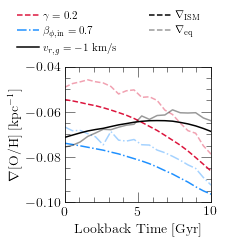

In [6]:
# LOOKBACKS = list(range(11))
LOOKBACKS = np.linspace(0, 10, 20)
# LABELS = [r"$\gamma = 0.2$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$v_{r,g} = -1$ km/s", "ORA Limit"]
LABELS = [r"$\gamma = 0.2$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$v_{r,g} = -1$ km/s"]
COLORS = ["crimson", "dodgerblue", "black", "lime"]
COLORS = ["crimson", "dodgerblue", "black"]
# LINESTYLES = ["--", "-.", "-", ":"]
LINESTYLES = ["--", "-.", "-"]
ALPHA = 0.4

fig = plt.figure(figsize = (3.3, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_ylabel(r"$\nabla$[O/H] [kpc$^{-1}$]")
ax.set_xlim([0, 10])
# ax.set_ylim([-0.2, -0.04])
ax.set_ylim([-0.1, -0.04])
# ax.set_yticks([-0.1, -0.05])

def plot_slope_evolution(output, zone_width = 0.1, **kwargs):
    slopes = []
    for i in range(len(LOOKBACKS)):
        slopes.append(ism_gradient(output, LOOKBACKS[i], zone_width = zone_width))
    ax.plot(LOOKBACKS, slopes, **kwargs)
    kwargs["label"] = None
    slopes = []
    for i in range(len(LOOKBACKS)):
        slopes.append(eq_gradient(output, LOOKBACKS[i], zone_width = zone_width))
    ax.plot(LOOKBACKS, slopes, alpha = ALPHA, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_slope_evolution(outputs[i], **kwargs)

ax.plot([100, 200], [100, 200], c = named_colors()["black"], linestyle = "--", label = r"$\nabla_\text{ISM}$")
ax.plot([100, 200], [100, 200], c = named_colors()["black"], linestyle = "--", alpha = ALPHA, label = r"$\nabla_\text{eq}$")

kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.3, 1.02),
    "fontsize": 11,
    "ncol": 2,
    "columnspacing": 3
}
ax.legend(**kwargs)

plt.tight_layout()
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("./equilibrium/slope-evolution-fiducial-models.%s" % (ext), **kwargs)
plt.show()

In [28]:
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/constant/vgas-1"
]
outputs = [vice.output(name) for name in outputs]

/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  mu += (vgas[i + 1] - vgas[i]) / (vgas[i] * zone_width)
/Users/astrobeard/Work/Research/milkyway/radial-flows/notebooks/../src/utils.py:94: RuntimeWarning: invalid value encountered in double_scalars
  mu *= -tau_star * vgas[i]


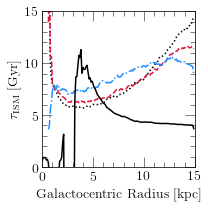

In [29]:
LABELS = [r"$v_{r,g} = 0$", r"$\gamma = 0.2$", r"$\beta_{\phi,\text{in}} = 0.7$", r"$v_{r,g} = -1$ km/s"]
COLORS = ["black", "crimson", "dodgerblue", "black"]
LINESTYLES = [":", "--", "-.", "-"]
LOOKBACK = 0

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\tau_\text{ISM}$ [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

def tau_ism_profile(output, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, LOOKBACK, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        mu_g = len(radii) * [0.]
    tau_ism = []
    diff = [abs(_ - LOOKBACK) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            taustar = eta = float("nan")
        recycling = zone.history["r_eff"][idx]
        tau_ism.append(taustar / (1 + eta - mu_g[i] - recycling))
    return [radii[:-1], tau_ism]

def plot_prediction(output, zone_width = 0.1, **kwargs):
    radii, tau_ism = tau_ism_profile(output, zone_width = zone_width)
    tau_ism = boxcarsmoothtrend(radii, tau_ism, window = 5)
    ax.plot(radii, tau_ism, **kwargs)
    
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i],
        "linestyle": LINESTYLES[i]
    }
    plot_prediction(outputs[i], **kwargs)
    
# kwargs = {
#     "loc": mpl_loc("upper left"),
#     "bbox_to_anchor": (0.1, 0.98),
#     "ncol": 1,
#     "handlelength": 1.5,
#     "fontsize": 10
# }
# leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/tauism-profiles.%s" % (ext), **kwargs)
plt.show()

In [3]:
outputs = [
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/constant/vgas-1"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_39511/277103466.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


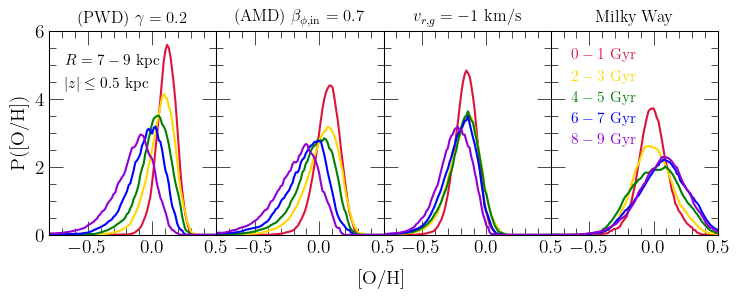

In [51]:
RMIN = 7
RMAX = 9
ABSZMAX = 0.5
COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]
AGEBINS = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
TITLES = [
    r"(PWD) $\gamma = 0.2$",
    r"(AMD) $\beta_{\phi,\text{in}} = 0.7$",
    r"$v_{r,g} = -1$ km/s",
    r"Milky Way"
]
# COLORS = ["black", "darkviolet", "navy", "blue", "green",
#     "lime", "gold", "darkorange", "crimson", "firebrick"]
# AGEBINS = list(range(11))

fig = plt.figure(figsize = (7.5, 3))
axes = []
for i in range(len(outputs) + 1):
    axes.append(fig.add_subplot(101 + 10 * (len(outputs) + 1) + i))
    axes[i].set_xlim([-0.8, 0.5])
    axes[i].set_ylim([0, 6])
    axes[i].set_xticks([-0.5, 0, 0.5])
    if i: plt.setp(axes[i].get_yticklabels(), visible = False)
    axes[i].set_title(TITLES[i], fontsize = 12)
dummy = fig.add_axes([0.1, 0.1, 0.8, 0.8], xticks = [], yticks = [], zorder = -1000)
dummy.set_xlabel(r"[O/H]", labelpad = 25)
axes[0].set_ylabel(r"P([O/H])")

def plot_model(ax, output, rmin, rmax, agemin, agemax, abszmax, zone_width = 0.1, **kwargs):
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<", int(rmax / zone_width - 1)).filter(
        "absz", "<=", abszmax).filter(
        "age", ">=", agemin).filter(
        "age", "<", agemax).filter(
        "mass", ">", 1)
    hist_kwargs = {
        "range": ax.get_xlim(),
        "bins": 100,
        "weights": stars["mass"],
        "density": True
    }
    dist, bins = np.histogram(stars["[o/h]"], **hist_kwargs)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    dist = boxcarsmoothtrend(xvals, dist, window = 5)
    ax.plot(xvals, dist, **kwargs)

def plot_data(ax, rmin, rmax, agemin, agemax, abszmax, **kwargs):
    stars = sample.filter(
        "galr", ">=", rmin).filter(
        "galr", "<=", rmax).filter(
        "astronn_age", ">=", agemin).filter(
        "astronn_age", "<", agemax).filter(
        "absz", "<=", abszmax)
    hist_kwargs = {
        "range": ax.get_xlim(),
        "bins": 100,
        "density": True
    }
    dist, bins = np.histogram(stars["o_h"], **hist_kwargs)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    dist = boxcarsmoothtrend(xvals, dist, window = 5)
    ax.plot(xvals, dist, **kwargs)

for i in range(len(outputs)):
    for j in range(len(AGEBINS)):
        kwargs = {
            "c": named_colors()[COLORS[j]],
            "label": r"$%d - %d$ Gyr" % (AGEBINS[j][0], AGEBINS[j][1])
        }
        plot_model(axes[i], outputs[i], RMIN, RMAX, AGEBINS[j][0], AGEBINS[j][1], ABSZMAX, **kwargs)

for j in range(len(AGEBINS)):
    kwargs = {
        "c": named_colors()[COLORS[j]],
        "label": r"$%d - %d$ Gyr" % (AGEBINS[j][0], AGEBINS[j][1])
    }
    plot_data(axes[-1], RMIN, RMAX, AGEBINS[j][0], AGEBINS[j][1], ABSZMAX, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.01, 0.98),
    "handlelength": 0,
    "ncol": 1,
    "fontsize": 11
}
leg = axes[-1].legend(**kwargs)
fancy_legend(leg, COLORS)

kwargs = {"fontsize": 11}
axes[0].text(-0.68, 5, r"$R = %d - %d$ kpc" % (RMIN, RMAX), **kwargs)
axes[0].text(-0.68, 4.3, r"$\left|z\right| \leq %g$ kpc" % (ABSZMAX), **kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0, bottom = 0.2)
dummy.set_position([
    axes[0].get_position().x0,
    axes[0].get_position().y0,
    axes[-1].get_position().x1 - axes[0].get_position().x0,
    axes[0].get_position().y1 - axes[0].get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/mdfs-solarcircle-agebins.%s" % (ext), **kwargs)
plt.show()

In [10]:
outputs = [
    "../outputs/river/insideout",
    "../outputs/potential-well-deepening/gamma0p2",
    "../outputs/angular-momentum-dilution/betaphiin0p7",
    "../outputs/constant/vgas-0",
    "../outputs/constant/vgas-0p5"
]
# outputs = [
#     "../outputs/river/insideout",
#     "../outputs/potential_well_deepening/gamma0p2",
#     "../outputs/amd/betaphiin0p7",
#     "../outputs/constant/vgas-0",
#     "../outputs/constant/vgas-0p5"
# ]
outputs = [vice.output(name) for name in outputs]

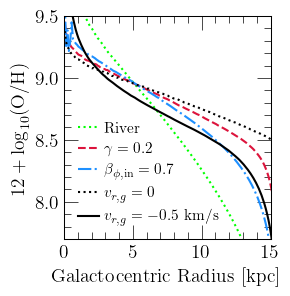

In [19]:
# COLORS = ["black", "black", "crimson", "crimson", "crimson", "dodgerblue", "dodgerblue", "dodgerblue", "lime"]
COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
# COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
LINESTYLES = [
    ":", # River
    "--", # PWD
    "-.", # AMD
    ":", # v = 0
    "-", # v = -0.5 km/s
]
LABELS = [
    "River",
    r"$\gamma = 0.2$",
    r"$\beta_{\phi,\text{in}} = 0.7$",
    r"$v_{r,g} = 0$",
    r"$v_{r,g} = -0.5$ km/s"
]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$12 + \log_{10}(\text{O/H})$")
ax.set_xlim([0, 15])
ax.set_ylim([7.7, 9.5])

def plot_profile(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = [output.zones["zone%d" % (i)].history["[o/h]"][idx] for i in range(len(radii))]
    oh = [oh_to_12pluslog(_) for _ in oh]
    ax.plot(radii, oh, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_profile(outputs[i], 0, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 1.4,
    "fontsize": 11
}
leg = ax.legend(**kwargs)

plt.tight_layout()
plt.subplots_adjust(top = 0.95)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/scenarios-profile-comp.%s" % (ext), **kwargs)
plt.show()

/var/folders/mh/jf6nfbl941l_41vvvwwk5wbr0000gn/T/ipykernel_72870/803564687.py:47: RuntimeWarning: invalid value encountered in log10
  logratio = [np.log10(r) for r in ratio]


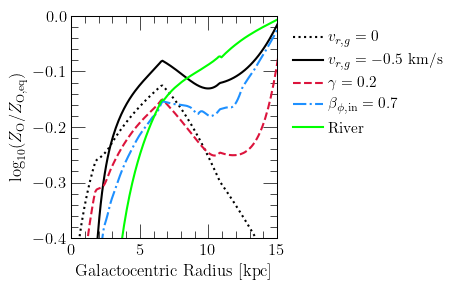

In [49]:
# COLORS = ["black", "black", "crimson", "crimson", "crimson", "dodgerblue", "dodgerblue", "dodgerblue", "lime"]
# COLORS = ["lime", "crimson", "dodgerblue", "black", "black"]
COLORS = ["black", "black", "crimson", "dodgerblue", "lime"]
LINESTYLES = [
    ":", # v = 0
    "-", # v = -0.5 km/s
    "--", # PWD
    "-.", # AMD
    "-", # River
]
LABELS = [
    r"$v_{r,g} = 0$",
    r"$v_{r,g} = -0.5$ km/s",
    r"$\gamma = 0.2$",
    r"$\beta_{\phi,\text{in}} = 0.7$",
    "River"
]

fig = plt.figure(figsize = (4.7, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\log_{10}(Z_\text{O} / Z_\text{O,eq})$")
ax.set_xlim([0, 15])
ax.set_ylim([-0.4, 0])
# ax.set_yscale("log")
# ax.set_ylim([0.03, 1])
# ax.set_ylim([0, 1])
# ax.set_yticks([0, 0.5, 1])
# ax.axhline(1, c = named_colors()["black"], linestyle = ":")

# norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
# cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
# cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
# # cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
# cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
# cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
# cbar.set_ticks(LOOKBACKS)

def plot_eqratioprofile(ax, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = zone_width)
    ratio = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        ratio.append(zone.history["z(o)"][idx] / zeq[i])
    logratio = [np.log10(r) for r in ratio]
    ax.plot(radii[:-1], logratio, **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        "label": LABELS[i]
    }
    plot_eqratioprofile(ax, outputs[i], 0, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (1.01, 0.99),
    "handlelength": 2,
    "fontsize": 11
}
ax.legend(**kwargs)

plt.tight_layout()
# plt.subplots_adjust(right = 0.88)
# cbar_ax.set_position([
#     ax.get_position().x1,
#     ax.get_position().y0,
#     0.05,
#     ax.get_position().y1 - ax.get_position().y0
# ])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./equilibrium/scenarios-eqratio-comp.%s" % (ext), **kwargs)
plt.show()

In [2]:
output = vice.output("../outputs/potential_well_deepening/gamma0p2")

NameError: name 'output' is not defined

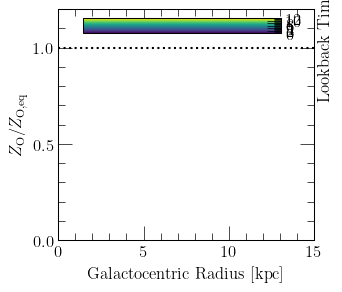

In [5]:
LOOKBACKS = [0, 2, 4, 6, 8, 10, 12]
COLORMAP = "viridis"

fig = plt.figure(figsize = (3.3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$Z_\text{O} / Z_\text{O,eq}$")
ax.set_xlim([0, 15])
ax.set_ylim([0, 1.2])
ax.set_yticks([0, 0.5, 1])
ax.axhline(1, c = named_colors()["black"], linestyle = ":")

norm = plt.Normalize(vmin = min(LOOKBACKS), vmax = max(LOOKBACKS))
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.05])
# cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "vertical")
cbar.set_label("Lookback Time [Gyr]", labelpad = 10)
cbar.set_ticks(LOOKBACKS)

def plot_eqprofile(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii, zeq = equilibrium_profile(output, lookback, zone_width = zone_width)
    ratio = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        ratio.append(zone.history["z(o)"][idx] / zeq[i])
    ax.plot(radii[:-1], ratio, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": cmap.to_rgba(LOOKBACKS[i])
    }
    plot_eqprofile(output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.88)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
plt.show()